# SIEM-lite Performance Analysis

This notebook analyzes the results from SIEM-lite experiments.

**Contents:**
1. Load experiment data
2. Throughput analysis
3. Latency distributions
4. Scalability analysis
5. Resource utilization
6. Bottleneck identification

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import glob
from pathlib import Path

sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

# Directories
RESULTS_DIR = '../results'
PLOTS_DIR = f'{RESULTS_DIR}/plots'
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

## 1. Load Experiment Data

In [14]:
# Find all metrics files
metrics_files = glob.glob(f'{RESULTS_DIR}/metrics_*.csv')
print(f'Found {len(metrics_files)} experiment results')

# Load all metrics
all_metrics = []
for f in metrics_files:
    # Parse filename: metrics_w{W}_r{R}_b{B}.csv
    parts = Path(f).stem.replace('metrics_', '').split('_')
    try:
        workers = int(parts[0][1:])
        rate = int(parts[1][1:])
        batch = int(parts[2][1:])
    except Exception:
        # skip malformed filenames
        continue

    df = pd.read_csv(f)
    df['workers'] = workers
    df['rate'] = rate
    df['batch'] = batch
    df['exp_id'] = f'w{workers}_r{rate}_b{batch}'
    all_metrics.append(df)

# Safely concat
if all_metrics:
    metrics_df = pd.concat(all_metrics, ignore_index=True)
else:
    metrics_df = pd.DataFrame()

metrics_df.head()

Found 7 experiment results


,timestamp,runtime_sec,events_processed,ingestion_queue_size,parsed_queue_size,cpu_percent,memory_mb,throughput_eps,alerts_count,workers,rate,batch,exp_id
0,2025-12-11T03:12:02.852135,5.0,0,0,0,0.0,26.1,0.0,49,1,200,100,w1_r200_b100
1,2025-12-11T03:12:07.955580,10.2,0,0,0,0.0,26.2,0.0,49,1,200,100,w1_r200_b100
2,2025-12-11T03:11:50.639943,5.0,0,0,0,0.0,26.4,0.0,91,1,200,50,w1_r200_b50
3,2025-12-11T03:11:55.742673,10.2,0,0,0,0.0,26.5,0.0,91,1,200,50,w1_r200_b50
4,2025-12-11T03:12:27.575928,5.0,0,0,0,0.0,26.6,0.0,329,1,500,100,w1_r500_b100


## 2. Throughput Analysis

In [15]:
# Calculate steady-state throughput (last 50% of each run)
steady_state = []
if not metrics_df.empty:
    for exp_id in metrics_df['exp_id'].unique():
        exp_data = metrics_df[metrics_df['exp_id'] == exp_id]
        mid = len(exp_data) // 2
        steady = exp_data.iloc[mid:]
        steady_state.append({
            'exp_id': exp_id,
            'workers': exp_data['workers'].iloc[0],
            'rate': exp_data['rate'].iloc[0],
            'batch': exp_data['batch'].iloc[0],
            'avg_throughput': steady.get('throughput_eps').mean(),
            'max_throughput': steady.get('throughput_eps').max(),
            'avg_cpu': steady.get('cpu_percent').mean(),
            'avg_memory': steady.get('memory_mb').mean()
        })
    ss_df = pd.DataFrame(steady_state)
    print('Top 10 configurations by throughput:')
    display(ss_df.nlargest(10, 'avg_throughput')[['exp_id', 'avg_throughput', 'workers', 'batch']])
else:
    ss_df = pd.DataFrame()
    print('No metrics available')

Top 10 configurations by throughput:


,exp_id,avg_throughput,workers,batch
0,w1_r200_b100,0.0,1,100
1,w1_r200_b50,0.0,1,50
2,w1_r500_b100,0.0,1,100
3,w1_r500_b50,0.0,1,50
4,w2_r200_b50,0.0,2,50
5,w2_r300_b100,0.0,2,100
6,w2_r500_b50,0.0,2,50


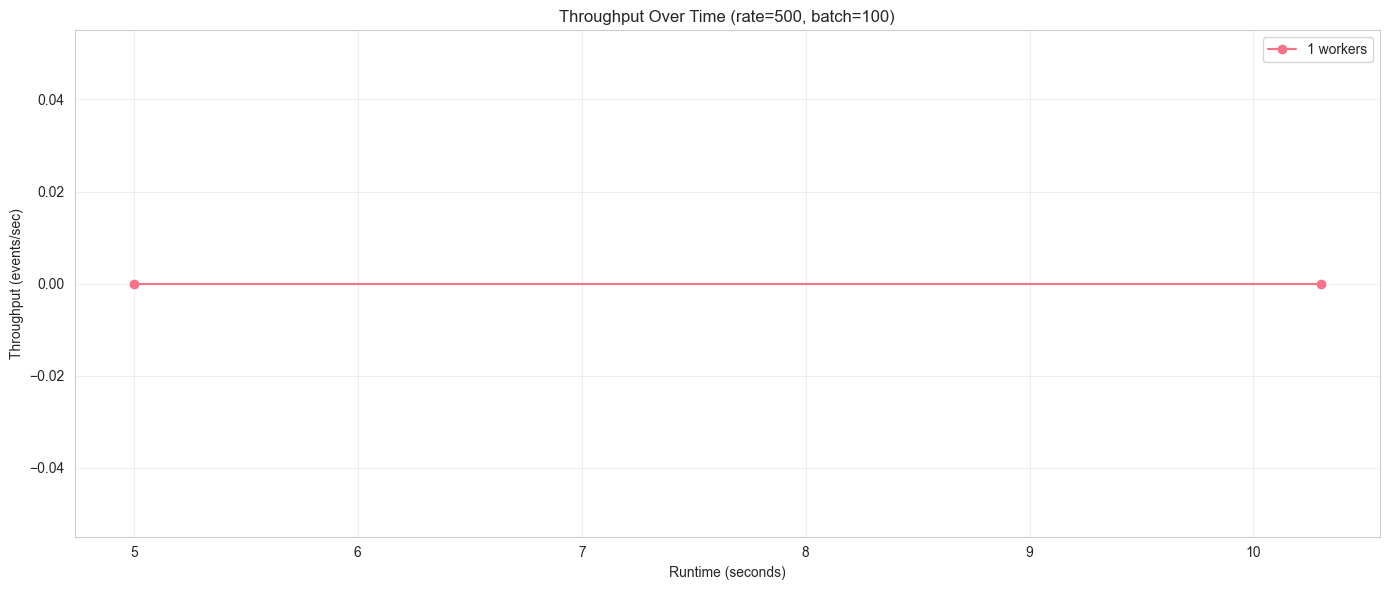

In [16]:
# Plot throughput over time (example config)
if not metrics_df.empty:
    fig, ax = plt.subplots(figsize=(14, 6))
    target_rate = 500
    target_batch = 100
    for workers in [1, 2, 4, 8]:
        subset = metrics_df[
            (metrics_df['workers'] == workers) &
            (metrics_df['rate'] == target_rate) &
            (metrics_df['batch'] == target_batch)
        ]
        if not subset.empty:
            ax.plot(subset['runtime_sec'], subset['throughput_eps'], marker='o', label=f'{workers} workers')
    ax.set_xlabel('Runtime (seconds)')
    ax.set_ylabel('Throughput (events/sec)')
    ax.set_title(f'Throughput Over Time (rate={target_rate}, batch={target_batch})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/throughput_over_time.png', dpi=300)
    plt.show()
else:
    print('No metrics to plot')

## 3. Scalability Analysis

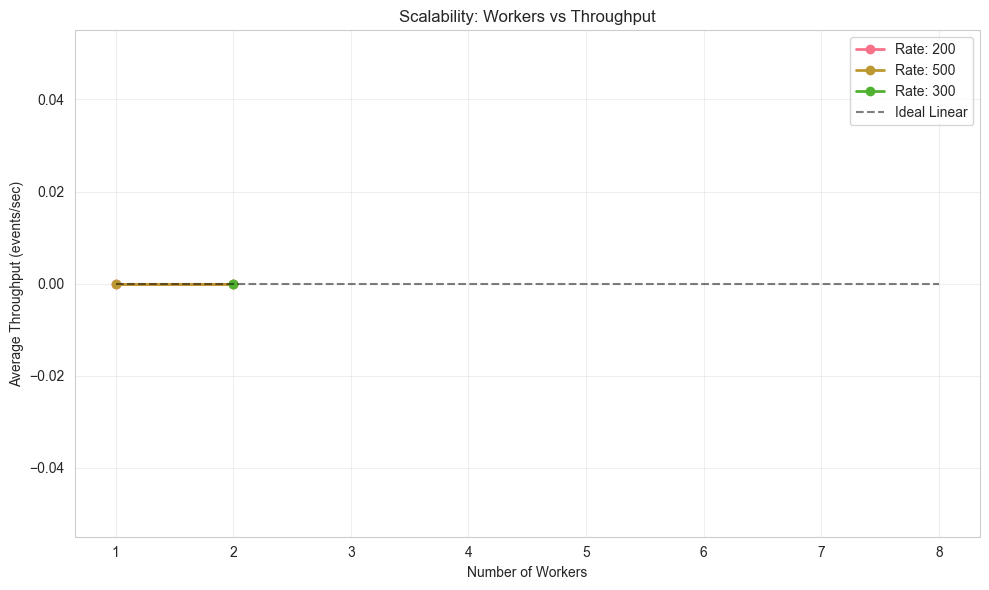

In [17]:
# Workers vs throughput (grouped by rate)
if not ss_df.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    for rate in ss_df['rate'].unique():
        subset = ss_df[ss_df['rate'] == rate].groupby('workers')['avg_throughput'].mean()
        ax.plot(subset.index, subset.values, marker='o', linewidth=2, label=f'Rate: {rate}')
    baseline = ss_df[ss_df['workers'] == 1]['avg_throughput'].mean() if 1 in ss_df['workers'].values else None
    if baseline is not None:
        ax.plot([1, 2, 4, 8], [baseline*i for i in [1, 2, 4, 8]], 'k--', alpha=0.5, label='Ideal Linear')
    ax.set_xlabel('Number of Workers')
    ax.set_ylabel('Average Throughput (events/sec)')
    ax.set_title('Scalability: Workers vs Throughput')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{PLOTS_DIR}/scalability.png', dpi=300)
    plt.show()
else:
    print('No steady-state data available')

## 4. Summary Report

In [18]:
print('='*60)
print('SIEM-LITE PERFORMANCE SUMMARY')
print('='*60)

if not ss_df.empty:
    print(f'\nTotal experiments: {len(ss_df)}')
    print('\n📊 Throughput:')
    print(f'  Peak: {ss_df["avg_throughput"].max():.0f} events/sec')
    best_config = ss_df.loc[ss_df['avg_throughput'].idxmax()]
    print(f'  Best config: w={best_config["workers"]}, batch={best_config["batch"]}')
    print('\n🔧 Resource Usage:')
    print(f'  Avg CPU: {ss_df["avg_cpu"].mean():.1f}%')
    print(f'  Avg Memory: {ss_df["avg_memory"].mean():.0f} MB')
else:
    print('No data available to summarize')

print('\n' + '='*60)

SIEM-LITE PERFORMANCE SUMMARY

Total experiments: 7

📊 Throughput:
  Peak: 0 events/sec
  Best config: w=1, batch=100

🔧 Resource Usage:
  Avg CPU: 0.4%
  Avg Memory: 27 MB

